In [1]:
#importing python classes and packages
import os
import cv2
import numpy as np
from keras.applications import ResNet50
#loading quantum computing ML classes
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC#loading quantum SVM algorithm

from sklearn.metrics import accuracy_score
import pickle
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.models import Sequential, load_model, Model
from keras.applications.resnet50 import preprocess_input
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import svm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt   
import warnings
warnings.filterwarnings('ignore')

In [2]:
#define and load class labels found in dataset
path = "Dataset"
labels = ['CC', 'EC', 'HGSC', 'LGSC', 'MC']
X = []
Y = []
print("Class Labels : "+str(labels))    

Class Labels : ['CC', 'EC', 'HGSC', 'LGSC', 'MC']


In [3]:
#define function to get class label of given image
def getLabel(name):
    index = -1
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index

In [4]:
#load dataset image and process them
if os.path.exists("model/X.txt.npy"):
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else: #if images not process then read and process image pixels
    X.clear()
    Y.clear()
    for root, dirs, directory in os.walk(path):#connect to dataset folder
        for j in range(len(directory)):#loop all images from dataset folder
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:                
                    img = cv2.imread(root+"/"+directory[j])#read images
                    img = cv2.resize(img, (80, 80))#resize image
                    X.append(img) #add image pixels to X array
                    label = getLabel(name)#get image label id
                    Y.append(label)#add image label                    
    X = np.asarray(X)#convert array as numpy array
    Y = np.asarray(Y)
    np.save('model/X.txt',X)#save process images and labels
    np.save('model/Y.txt',Y)
print("Dataset images loaded")
print("Total images found in dataset : "+str(X.shape[0]))
print()

Dataset images loaded
Total images found in dataset : 31203



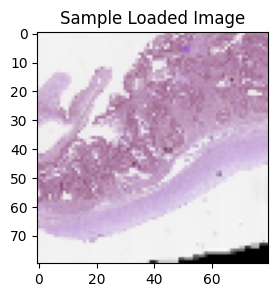

In [5]:
#displaying sample loaded image
X = np.load('model/X1.txt.npy')
Y = np.load('model/Y1.txt.npy')
img = X[0]
X = preprocess_input(X)
plt.figure(figsize=(4, 3))
plt.imshow(img)
plt.title("Sample Loaded Image")
plt.show()

In [6]:
#shuffling and splitting images into train and test
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) #split dataset into train and test
print("Dataset Train & Test Split Completed")

Dataset Train & Test Split Completed


In [7]:
#loading resnet model and then extracting features
resnet = ResNet50(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), include_top=False, weights='imagenet')
for layer in resnet.layers[:-8]:
  layer.trainable = False
resnet_model = Sequential()
resnet_model.add(resnet)
resnet_model.add(Flatten())
resnet_model.add(Dense(units = 256, activation = 'relu'))
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))
resnet_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/resnet_weights.keras") == False:
    model_check_point = ModelCheckpoint(filepath='model/resnet_weights.keras', verbose = 1, save_best_only = True)
    hist = resnet_model.fit(X_train, y_train, batch_size = 32, epochs = 25, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/resnet_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    resnet_model.load_weights("model/resnet_weights.keras")
#extracting features using resnet50
features_model = Model(resnet_model.inputs, resnet_model.layers[-3].output)#create resnet  model
if os.path.exists("model/resnet_features.npy"):
    resnet_features = np.load("model/resnet_features.npy")
    resnet_label = np.load("model/resnet_label.npy")
else:
    resnet_features = features_model.predict(X)  #extracting resnet features
    np.save("model/resnet_features", resnet_features)
    Y = np.argmax(Y, axis=1)
    np.save("model/resnet_label", Y)
print("Total features extracted from each image using ResNet50 = "+str(resnet_features.shape[1]))    

2025-09-03 17:09:48.871922: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-09-03 17:09:48.872065: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-09-03 17:09:48.872300: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-09-03 17:09:48.872875: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-03 17:09:48.873580: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
Total features extracted from each image using ResNet50 = 256


In [8]:
#defining quantum SVM classes object and then splitting resnet features into train and test
X_train, X_test, y_train, y_test = train_test_split(resnet_features, resnet_label, test_size=0.2) #split dataset into train and test
adhoc_feature_map = ZZFeatureMap(feature_dimension=10, reps=2, entanglement="linear")
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)
#creating Quantum SVM class obajcet
svm_cls = QSVC(quantum_kernel=adhoc_kernel)
svm_cls = svm.SVC()
svm_cls.fit(X_train, y_train)
predict = svm_cls.predict(X_test)
a = accuracy_score(y_test,predict)*100
p = precision_score(y_test, predict,average='macro') * 100
r = recall_score(y_test, predict,average='macro') * 100
f = f1_score(y_test, predict,average='macro') * 100
algorithm = "Quantum SVM"
print(algorithm+" Accuracy  :  "+str(a))
print(algorithm+" Precision : "+str(p))
print(algorithm+" Recall    : "+str(r))
print(algorithm+" FScore    : "+str(f))    

Quantum SVM Accuracy  :  92.2
Quantum SVM Precision : 93.5906033761561
Quantum SVM Recall    : 90.15704534197185
Quantum SVM FScore    : 91.60093568500353


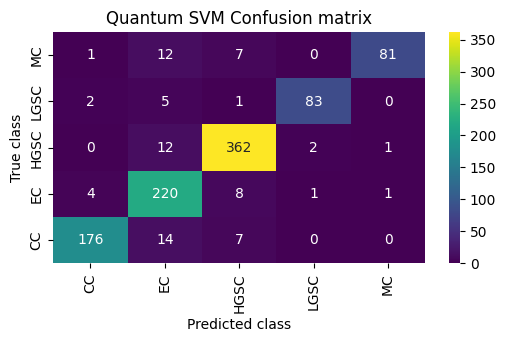

In [9]:
#displaying classification confusion matrix graph
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, predict) 
plt.figure(figsize =(6, 3)) 
ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
ax.set_ylim([0,len(labels)])
plt.title(algorithm+" Confusion matrix") 
plt.xticks(rotation=90)
plt.ylabel('True class') 
plt.xlabel('Predicted class') 
plt.show()    

In [10]:
# --- CNN Model Training & Evaluation ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import load_model
import os

# Load preprocessed dataset
X = np.load("model/X.txt.npy")
Y = np.load("model/Y.txt.npy")

# Normalize pixel values
X = X.astype('float32') / 255.0

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

# Path to save CNN model
cnn_model_path = "model/cnn_model.h5"

if os.path.exists(cnn_model_path):
    print("Loading saved CNN model...")
    cnn_model = load_model(cnn_model_path)
else:
    print("Training new CNN model...")
    cnn_model = Sequential()
    cnn_model.add(Conv2D(32, (3,3), activation='relu', input_shape=(80,80,3)))
    cnn_model.add(MaxPooling2D((2,2)))
    cnn_model.add(Conv2D(64, (3,3), activation='relu'))
    cnn_model.add(MaxPooling2D((2,2)))
    cnn_model.add(Conv2D(128, (3,3), activation='relu'))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(128, activation='relu'))
    cnn_model.add(Dense(len(np.unique(Y)), activation='softmax'))

    cnn_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    cnn_model.fit(X_train, y_train, epochs=10, batch_size=32,
                  validation_data=(X_test, y_test), verbose=1)

    # Save trained model
    cnn_model.save(cnn_model_path)
    print("CNN model saved to", cnn_model_path)

# Predictions
y_pred_cnn = np.argmax(cnn_model.predict(X_test), axis=1)




Loading saved CNN model...


2025-09-03 17:10:13.578258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step


CNN Accuracy  :  41.88431341131229
CNN Precision : 41.66264490980057
CNN Recall    : 32.495948080275284
CNN FScore    : 28.57704921651819


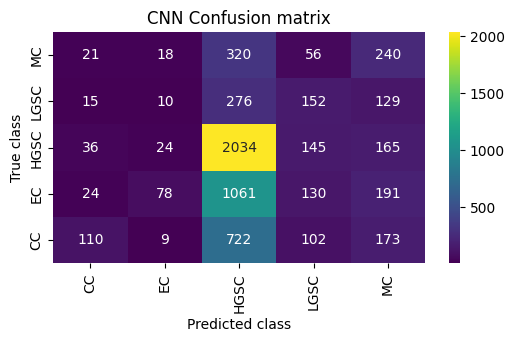

In [11]:


# CNN Metrics
a_cnn = accuracy_score(y_test, y_pred_cnn) * 100
p_cnn = precision_score(y_test, y_pred_cnn, average='macro') * 100
r_cnn = recall_score(y_test, y_pred_cnn, average='macro') * 100
f_cnn = f1_score(y_test, y_pred_cnn, average='macro') * 100

algorithm = "CNN"
print(algorithm+" Accuracy  :  "+str(a_cnn))
print(algorithm+" Precision : "+str(p_cnn))
print(algorithm+" Recall    : "+str(r_cnn))
print(algorithm+" FScore    : "+str(f_cnn))

# Confusion Matrix for CNN
conf_matrix_cnn = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize =(6, 3))
ax = sns.heatmap(conf_matrix_cnn, xticklabels=labels, yticklabels=labels, annot=True, cmap="viridis", fmt="g")
ax.set_ylim([0,len(labels)])
plt.title(algorithm+" Confusion matrix")
plt.xticks(rotation=90)
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


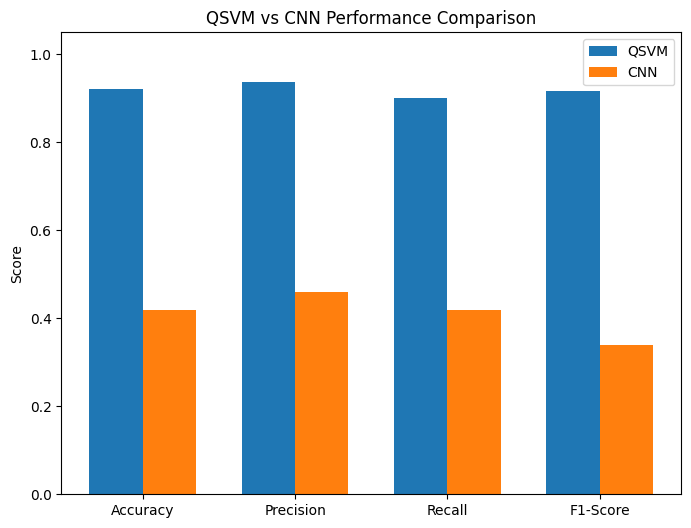

In [12]:
# --- QSVM (already computed) ---
acc_qsvm = a / 100   # convert back to fraction
prec_qsvm = p / 100
rec_qsvm = r / 100
f1_qsvm = f / 100

# --- CNN (already computed) ---
acc_cnn = accuracy_score(y_test, y_pred_cnn)
prec_cnn = precision_score(y_test, y_pred_cnn, average='weighted')
rec_cnn = recall_score(y_test, y_pred_cnn, average='weighted')
f1_cnn = f1_score(y_test, y_pred_cnn, average='weighted')

# --- Bar Graph Comparison ---
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
qsvm_scores = [acc_qsvm, prec_qsvm, rec_qsvm, f1_qsvm]
cnn_scores  = [acc_cnn, prec_cnn, rec_cnn, f1_cnn]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,6))
plt.bar(x - width/2, qsvm_scores, width, label='QSVM')
plt.bar(x + width/2, cnn_scores, width, label='CNN')

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.ylim(0, 1.05)  # since now all are between 0–1
plt.title("QSVM vs CNN Performance Comparison")
plt.legend()
plt.show()


In [13]:
#use this function to predict fish species uisng extension model
def predict(image_path):
    image = cv2.imread(image_path)#read test image
    img = cv2.resize(image, (80, 80))#resize image
    img = img.reshape(1,80,80,3)#convert image as 4 dimension
    img = preprocess_input(img)
    features = features_model.predict(img)  #extracting resnet features
    predict = svm_cls.predict(features)#applying quantum svm on resnet features for classification
    predict = predict[0]
    img = cv2.imread(image_path)
    img = cv2.resize(img, (400,300))#display image with predicted output
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.putText(img, 'Predicted As : '+labels[predict], (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 0, 255), 2)
    plt.figure(figsize=(4, 3))
    plt.imshow(img)
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


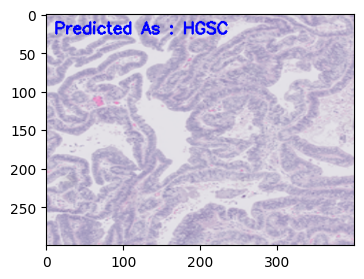

In [14]:
#call this function with test image to predict monkeypox
predict("testImages/1.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


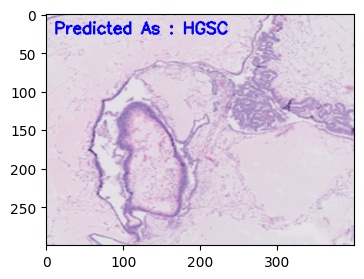

In [15]:
#call this function with test image to predict monkeypox
predict("testImages/0.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


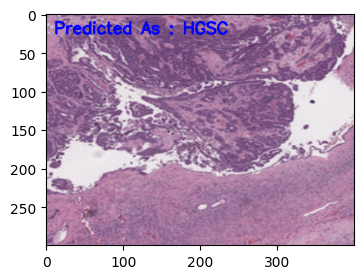

In [16]:
#call this function with test image to predict monkeypox
predict("testImages/2.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


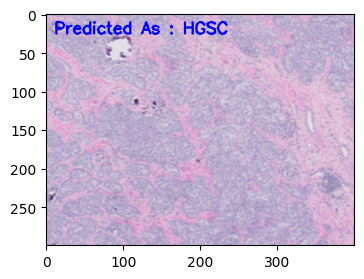

In [17]:
#call this function with test image to predict monkeypox
predict("testImages/3.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


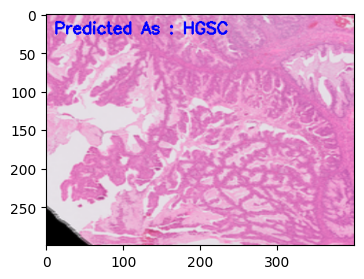

In [18]:
#call this function with test image to predict monkeypox
predict("testImages/4.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


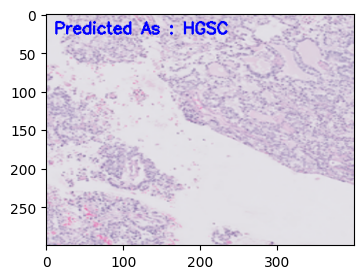

In [19]:
predict("testImages/9.png")